# Supervised Autoencoder on CIFAR-10 — Notebook Template

**Goal:** Train a supervised autoencoder (reconstruction + classification) on CIFAR-10, with clear verification at each step.

> Fill in the TODOs step-by-step. Each section contains a brief checklist and sanity checks.

_Generated: 2025-10-21T11:48:40.685883Z_

## Environment & Reproducibility
- [ ] Select device (CPU/GPU)
- [ ] Set random seeds
- [ ] (Optional) Enable cudnn benchmark

**Verify:** print device; run a tiny tensor op.

In [1]:
import os
import math
import random
from pathlib import Path
import numpy as np
import random
import torch
import torchvision

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


## Config
- [ ] Define a simple config dict (dataset paths, batch size, latent_dim, λ, lr)
- [ ] Pri
nt config to confirm

**Tip:** Start simple; you can move this to YAML later.

In [2]:
# TODO: create a minimal config
CONFIG = {
    # ---------- Data ----------
    'data_root'        : '../data_02',
    'num_classes'      : 10,
    'batch_size'       : 128,
    'augment'          : True,          # basic flips/crops/etc.
    'num_workers'      : 4,
    'img_size'         : 32,            # CIFAR-10 native
    'split_train'      : 0.8,           # 0.8 train / 0.2 val (renamed from split_val for clarity)

    # ---------- Model ----------
    'latent_dim'       : 128,            # try 32/128 later
    'loss_type'        : 'mse',         # reconstruction: 'mse' or 'bce'
    'lambda_recon'     : 1,          # defautl: 0.25weight for reconstruction loss

    # ---------- Optimizer ----------
    'lr'               : 5e-4,
    'weight_decay'     : 0, # built-in L2 regularization (weight_decay): 1e-4

    # ---------- Training loop ----------
    'epochs'           : 60,            # -> int, number of epochs
    'grad_accum_steps' : 1,             # set >1 if batches are large
    'clip_grad_norm'   : None,          # e.g., 1.0 to enable clipping
    'use_amp'          : True,          # mixed precision training
    'log_interval'     : 50,            # print every N steps

    # ---------- Validation / Selection ----------
    'best_metric'      : 'acc',         # 'acc' (higher is better) or 'loss' (lower is better)
    'early_stop_patience': 3,           # stop if no improvement for N val epochs

    # ---------- Checkpointing (optional) ----------
    'ckpt_path'        : '../checkpoints/best.pt',  # None to disable

    # ---------- Scheduler (optional) ----------
    'scheduler'        : None,          # e.g., 'cosine', 'step', or None
    'scheduler_epoch'  : True,          # True: step per epoch; False: step per iteration
    'scheduler_kwargs' : {},            # e.g., {'T_max': 20} for cosine

    # ---------- Device (optional override) ----------
    'device'           : 'cuda',        # or 'cpu'; you can auto-detect in code instead
}

from pprint import pprint
pprint(CONFIG)

{'augment': True,
 'batch_size': 128,
 'best_metric': 'acc',
 'ckpt_path': '../checkpoints/best.pt',
 'clip_grad_norm': None,
 'data_root': '../data_02',
 'device': 'cuda',
 'early_stop_patience': 3,
 'epochs': 60,
 'grad_accum_steps': 1,
 'img_size': 32,
 'lambda_recon': 1,
 'latent_dim': 128,
 'log_interval': 50,
 'loss_type': 'mse',
 'lr': 0.0005,
 'num_classes': 10,
 'num_workers': 4,
 'scheduler': None,
 'scheduler_epoch': True,
 'scheduler_kwargs': {},
 'split_train': 0.8,
 'use_amp': True,
 'weight_decay': 0}


## Data Pipeline (CIFAR-10)
- [ ] Define train/val/test transforms
- [ ] Build DataLoaders
- [ ] Print batch shapes and pixel ranges

**Verify:** `(B, 3, 32, 32)` and labels shape `(B,)`.

In [3]:
# TODO: write the strategy to explain the no normalization
from typing import Tuple
import torchvision.transforms as T
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader, Subset, random_split

def get_transforms(augment: bool = True):
    
    train_tfms = T.Compose([
        T.RandomCrop(32, padding=4),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        ])
    
    test_val_tfms = T.Compose([
            T.ToTensor(),
        ])
    
    if augment is True:
        return train_tfms, test_val_tfms
    
    else:
        train_tfms = test_val_tfms
        return train_tfms, test_val_tfms
        
def get_dataloaders(cfg) -> Tuple[object, object, object]:

    train_tfms, test_tfms = get_transforms(cfg['augment'])
    
    # Instantiate the dataset
    test_set = CIFAR10(root=cfg['data_root'], train=False, transform= test_tfms, download = True)
    
    augment_train_set = CIFAR10(root=cfg['data_root'], train=True, transform= train_tfms, download = True)
    no_augment_train_set = CIFAR10(root=cfg['data_root'], train=True, transform= test_tfms, download = True)
    
    # split the full training data into train and validation sets
    train_size: int = int(cfg['split_train'] * len(augment_train_set))
    valid_size: int = len(augment_train_set) - train_size
    
    # get the list of indices
    dataset_indices = list(range(0, len(augment_train_set))) 

    random.seed(SEED)  
    shuffled_dataset_indices = random.sample(dataset_indices , k=len(dataset_indices))
    
    train_idx = shuffled_dataset_indices[:train_size]
    val_idx = shuffled_dataset_indices[train_size:]
    
    # Get the train_set and valid_set    
    train_set = Subset(dataset= augment_train_set, indices= train_idx)
    valid_set = Subset(dataset= no_augment_train_set, indices= val_idx)       
    
    # Instantiate the DataLoaders
    train_loader = DataLoader(
        dataset=train_set,
        batch_size=cfg["batch_size"],
        shuffle=True,               # always shuffle training data
        drop_last=True,             # optional but recommended for batchnorm stability
        pin_memory=True,            # speeds up transfers to GPU
        persistent_workers=True,    # avoids worker respawn overhead (if num_workers>0)
        num_workers=cfg["num_workers"]
    )
    
    valid_loader = DataLoader(
        dataset=valid_set,
        batch_size=cfg["batch_size"],
        shuffle=False,              # never shuffle validation data
        drop_last=False,
        pin_memory=True,
        persistent_workers=True,
        num_workers=cfg["num_workers"]
    )
    
    test_loader = DataLoader(
        dataset=test_set,
        batch_size=cfg["batch_size"],
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        persistent_workers=True,
        num_workers=cfg["num_workers"]
    )
    
    # print dataset sizes
    print(f"All samples: {len(train_set)+len(valid_set)+len(test_set)}")
    print(f"Train samples: {len(train_set)}")
    print(f"Validation samples: {len(valid_set)}")
    print(f"Test samples: {len(test_set)}")

    # get one sample to check image shape
    image, label = augment_train_set[0]
    print(f"Single image shape: {image.shape}")
    
    return train_loader, valid_loader,test_loader

# Get the dataloader
train_loader, valid_loader,test_loader = get_dataloaders(CONFIG)
images, labels = next(iter(train_loader))

print(
    f"\n[INFO] Dataset summary:\n"
    f"       Images shape : {images.shape}\n"
    f"       Labels shape : {labels.shape}\n"
    f"       Pixel range  : [{images.min().item()}, {images.max().item()}]"
)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
All samples: 60000
Train samples: 40000
Validation samples: 10000
Test samples: 10000
Single image shape: torch.Size([3, 32, 32])

[INFO] Dataset summary:
       Images shape : torch.Size([128, 3, 32, 32])
       Labels shape : torch.Size([128])
       Pixel range  : [0.0, 1.0]


## View a batch of images

In [4]:
# TODO: Get the label directly cifar10_classes = cifar10.classes

cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(cifar10_classes [labels[0]])  

car


Shape before transpose: (3, 546, 274)
Shape after transpose: (546, 274, 3)


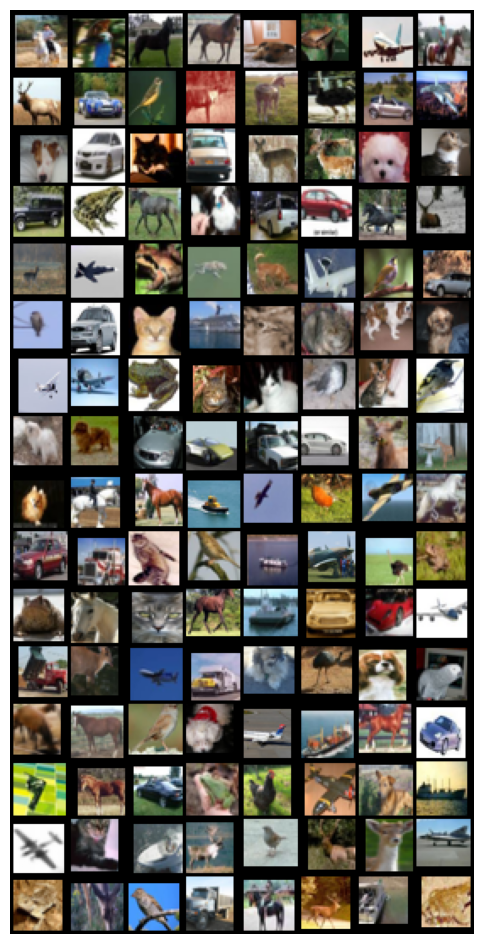

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# TODO: check the bug -> it is not an 8 by 8 figure, why?
# Helper function to display an image grid
def show_image(image_tensor: torch.Tensor) -> None:
    """Convert a PyTorch tensor into a viewable image grid and show it."""

    # Step 1 Undo normalization: normalised = (original - 0.5) / 0.5] -> normalised * 2 +0.5 = original
    # unnormalized_image_grid = image_tensor * 0.5 + 0.5

    # Step 2: Convert from a PyTorch tensor to a NumPy array (for matplotlib)
    # .detach() removes gradient tracking; .cpu() ensures data is on the CPU.
    image_grid_C_H_W = image_tensor.detach().cpu().numpy()
    
    print("Shape before transpose:", image_grid_C_H_W.shape)  
    # (C, H, W) → C = number of color channels (3 for RGB), H = height, W = width

    # Step 3: Rearrange dimensions from (C, H, W) to (H, W, C)
    # because Matplotlib expects the color channel as the last dimension.
    image_grid_H_W_C = np.transpose(image_grid_C_H_W, (1, 2, 0))
    print("Shape after transpose:", image_grid_H_W_C.shape)   # (H, W, C)

    # Step 4: Display the image
    plt.figure(figsize=(12, 12))
    plt.imshow(image_grid_H_W_C)
    plt.axis("off")  # hide axis numbers
    plt.show()
    
# Get a batch of training images
data_iter: iter = iter(train_loader)  # Create an iterator for the DataLoader
images: torch.Tensor
labels: torch.Tensor
images, labels = next(data_iter)   # Get one batch (images + labels)

# Make a grid from the batch
image_grid: torch.Tensor = torchvision.utils.make_grid(images, nrow=8)  # 8 images per row


# Show the grid
show_image(image_grid)

## Model — Encoder, Decoder, Classifier Head, SupervisedAE
- [ ] Implement `Encoder` → `z`
- [ ] Implement `Decoder` ← `z`
- [ ] Implement `ClassifierHead` (MLP on `z` → 10 logits)
- [ ] Implement `SupervisedAE.forward(x) → (z, x_hat, logits)`

**Verify:** Check shapes for a dummy batch.

In [6]:
import torch
import torch.nn as nn
from torch.nn.utils import clip_grad_norm_
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics import MeanSquaredError

### Encoder and decoder 

In [7]:
import torch.nn as nn
# TODO: use config for latent dim
class Encoder(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        # TODO: conv → bn → relu blocks with downsampling to small spatial map
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        # 32→16→8→4
        self.flat_dim = 128*4*4 # = 2048
                
        # Learnable linear projection: compress 2048-dim feature vector → latent_dim embedding (bottleneck)
        self.to_latent = nn.Linear(self.flat_dim, latent_dim)
        
    def forward(self, x):
        # return z the latent vector of shape (B, latent_dim)
        features = self.encoder_cnn(x)
        features_flat = features.flatten(1)
        z = self.to_latent(features_flat)
        # TODO: add in config
        if self.training:
            z = z + 0.1 * torch.randn_like(z) # Add Gaussian noise (only during training) 0.02 – 0.05-> removes the gap between the rmse train and valid
        return z
    
class Decoder(nn.Module):
    def __init__(self, latent_dim: int = 64):
        super().__init__()
        # linear → reshape → convtranspose blocks back to (B,3,32,32)
        
        self.flat_dim = 128*4*4 # = 2048
        
        self.to_feature_vector = nn.Linear(latent_dim, self.flat_dim, )
        
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.GELU(),
            # nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2,padding=1, bias=False),
            nn.BatchNorm2d(num_features=32),
            nn.GELU(),
            # nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=4, stride=2, padding=1, bias=True),
            nn.Sigmoid()
        )

    def forward(self, z):
        # return recon_features (x_hat) in [0,1] if using BCE, or unbounded for MSE
        features =self.to_feature_vector(z).reshape(z.size(0), 128, 4, 4) 
        recon_features = self.decoder_cnn(features)
    
        return recon_features

In [8]:
# Check: Encoder class
random_tensor = torch.rand(size = (8, 3, 32, 32))
encoder_trial = Encoder(latent_dim = 64)
latent_vector = encoder_trial.forward(random_tensor)
print("expected latent vector shape:",latent_vector.shape)

# Check: Decoder class
decoder_trial = Decoder()
recon_tensor = decoder_trial.forward(latent_vector)
print("expected reconstructed shape:", recon_tensor.shape)

expected latent vector shape: torch.Size([8, 64])
expected reconstructed shape: torch.Size([8, 3, 32, 32])


### Classifier

In [9]:
import torch.nn as nn

class ClassifierHead(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10):
        super().__init__()
        self.hidden_dim = 128  # small, expressive hidden layer
        
        # Simple MLP: z → hidden → logits
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, self.hidden_dim),
            nn.BatchNorm1d(self.hidden_dim),  # normalize 2D features
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),              # ↑ a bit
            nn.Linear(self.hidden_dim, num_classes)  # outputs raw logits for 10 classes
        )

    def forward(self, z):
        # Return logits (no softmax — handled by CrossEntropyLoss)
        logits = self.mlp(z)
        return logits

In [10]:
z = torch.randn(8, 64)
head = ClassifierHead(64, 10)
logits = head(z)
print(logits.shape)  # should be (8, 10)


torch.Size([8, 10])


### Supervised autoencoder

In [11]:
import torch
import torch.nn as nn

class SupervisedAE(nn.Module):
    def __init__(self, latent_dim: int = 64, num_classes: int = 10, lambda_recon: float = 0.25):
        super().__init__()
        # STEP 1 — Instantiate submodules
        # Encoder: takes (B,3,32,32) → (B, latent_dim)
        self.encoder = Encoder(latent_dim=latent_dim) 
        
        # Decoder: takes (B, latent_dim) → (B,3,32,32) with values in [0,1]
        self.decoder = Decoder(latent_dim=latent_dim) 
        
        # ClassifierHead: takes (B, latent_dim) → (B, num_classes) logits
        self.head = ClassifierHead(latent_dim=latent_dim, num_classes=num_classes)

        # STEP 2 — (Optional) Save hyperparameters you’ll want later (e.g., for loss weighting)
        self.latent_dim   = latent_dim
        self.num_classes  = num_classes
        self.lambda_recon = lambda_recon
        
    def forward(self, x):
        """
        Define the forward pass
          Input:
            x : tensor of shape (B, 3, 32, 32) with values in [0,1]
          Returns:
            z       : (B, latent_dim)      — latent representation
            x_hat   : (B, 3, 32, 32)       — reconstruction in [0,1]
            logits  : (B, num_classes)     — unnormalized class scores
        """
        # Encode image to latent
        z = self.encoder(x)

        # Decode latent back to image
        x_hat = self.decoder(z)

        # Classify from the same latent (no detach — let gradients flow into encoder)
        logits = self.head(z)

        # 4d) Return all three for downstream loss computation / metrics
        return z, x_hat, logits

## Losses
- [ ] Reconstruction loss (MSE or BCE)
- [ ] Classification loss (CrossEntropy)
- [ ] Total loss = CE + λ * Recon (+ optional L2 on z)

**Verify:** scalar outputs; grads flow to encoder/decoder/head.

In [12]:
import torch.nn as nn
import torch.nn.functional as F

def reconstruction_loss(x_hat, x, loss_type='mse'):
    """
    Compute reconstruction loss between model output and input.
    loss_type: 'mse' or 'bce' (extendable).
    """
    if loss_type == 'mse':
        return F.mse_loss(x_hat, x)
    elif loss_type == 'bce':
        return F.binary_cross_entropy(x_hat, x)
    else:
        raise NotImplementedError(f"Loss type '{loss_type}' not implemented.")


def classification_loss(logits, y):
    """
    Compute classification loss (CrossEntropyLoss expects raw logits).
    """
    return F.cross_entropy(logits, y)


def total_loss(logits, x_hat, y, x, lambda_recon: float = 0.25, loss_type='mse'):
    """
    Combine classification and reconstruction losses.
    Returns total loss, classification loss, and reconstruction loss.
    """
    recon_loss = reconstruction_loss(x_hat, x, loss_type)
    cls_loss   = classification_loss(logits, y)
    total_loss = cls_loss + lambda_recon * recon_loss 
    
    return total_loss, cls_loss, recon_loss




# Training Loop
- [ ] Build optimizer + (optional) scheduler
- [ ] Train for N epochs, log running losses & accuracy
- [ ] Validate each epoch; keep best checkpoint

**Verify:** both CE and recon losses decrease; accuracy > random.

https://github.com/ageron/handson-mlp/blob/main/18_autoencoders_gans_and_diffusion_models.ipynb

In [13]:
import torchmetrics

@torch.no_grad()
def evaluate(model, loader, device, loss_type):
    model.eval()
    acc = MulticlassAccuracy(num_classes=model.num_classes).to(device)
    rmse = MeanSquaredError(squared=False).to(device)
    tot_loss = 0.0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        _, x_hat, logits = model(X)
        loss, cls, rec = total_loss(logits, x_hat, y, X, model.lambda_recon, loss_type)
        tot_loss += loss.item()
        acc.update(logits, y)      # logits ok; argmax applied internally
        rmse.update(x_hat, X)
    n = len(loader)
    return {
        "loss": tot_loss / n,
        "acc": acc.compute().item(),
        "rmse": rmse.compute().item(),
    }

def train(model, optimizer, train_loader, valid_loader, n_epochs=10, device=None,
          max_grad_norm=1.0, scheduler_patience=2, scheduler_factor=0.5, loss_type='mse'):
    
    device = device or ("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    acc_tm = MulticlassAccuracy(num_classes=model.num_classes).to(device)
    rmse_tm = MeanSquaredError(squared=False).to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="max", patience=scheduler_patience, factor=scheduler_factor
    )

    history = {"train_loss": [], "train_acc": [], "train_rmse": [],
               "val_loss": [], "val_acc": [], "val_rmse": []}

    for epoch in range(1, n_epochs + 1):
        model.train()
        acc_tm.reset(); rmse_tm.reset()
        running = 0.0

        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            z, x_hat, logits = model(X)
                        
            # Regularization strength (tune between 1e-4 and 1e-2)
            l1_loss = 5e-2 * z.abs().mean()  # penalize large activations
            
            loss, _, _,= total_loss(logits, x_hat, y, X, model.lambda_recon, loss_type)
                        
            # Add the L1 regularization term
            loss = loss + l1_loss

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            clip_grad_norm_(model.parameters(), max_norm=max_grad_norm)
            optimizer.step()

            running += loss.item()
            acc_tm.update(logits, y)
            rmse_tm.update(x_hat, X)

        train_loss = running / len(train_loader)
        train_acc = acc_tm.compute().item()
        train_rmse = rmse_tm.compute().item()

        # ---- validation
        val_metrics = evaluate(model, valid_loader, device, loss_type)
        scheduler.step(val_metrics["acc"])  # plateau on validation accuracy

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["train_rmse"].append(train_rmse)
        history["val_loss"].append(val_metrics["loss"])
        history["val_acc"].append(val_metrics["acc"])
        history["val_rmse"].append(val_metrics["rmse"])

        print(f"Epoch {epoch:02d}/{n_epochs} | "
              f"train: loss {train_loss:.4f}, acc {train_acc:.3f}, rmse {train_rmse:.4f} | "
              f"val: loss {val_metrics['loss']:.4f}, acc {val_metrics['acc']:.3f}, rmse {val_metrics['rmse']:.4f}")

    return history

# Gridsearch

In [14]:
# import torch
# import pandas as pd
# from copy import deepcopy
# from tqdm import tqdm

# # --- your config baseline ---
# BASE_CONFIG = {
#     "num_classes": 10,
#     "epochs": 30,
#     "lr": 1e-4,
#     "loss_type": "mse",
# }

# # --- search ranges ---
# lambda_values = [0, 0.25, 0.5, 0.75, 1.0, 1.25]
# latent_dims   = [32, 64, 128]

# # --- storage ---
# results = []

# # --- grid search loop ---
# for latent_dim in latent_dims:
#     for lambda_recon in lambda_values:

#         print(f"\n🔹 Training model with latent_dim={latent_dim}, λ_recon={lambda_recon}")
#         cfg = deepcopy(BASE_CONFIG)
#         cfg.update({"latent_dim": latent_dim, "lambda_recon": lambda_recon})

#         # Instantiate model
#         model = SupervisedAE(
#             latent_dim=cfg["latent_dim"],
#             num_classes=cfg["num_classes"],
#             lambda_recon=cfg["lambda_recon"]
#         )

#         # Optimizer
#         optimizer = torch.optim.NAdam(model.parameters(), lr=cfg["lr"], weight_decay=0)

#         # Train
#         hist = train(
#             model, optimizer,
#             train_loader, valid_loader,
#             n_epochs=cfg["epochs"],
#             loss_type=cfg["loss_type"]
#         )

#         # Evaluate on validation set for metrics
#         val_metrics = evaluate(model, valid_loader, device, loss_type='mse')
        

#         results.append({
#             "latent_dim": latent_dim,
#             "lambda_recon": lambda_recon,
#             "val_acc": val_metrics["acc"],
#             "val_rmse": val_metrics["rmse"],
#             "val_loss": val_metrics["loss"],
#         })

# # --- summary table ---
# df = pd.DataFrame(results)
# print("\n===== Grid Search Results =====")
# print(df.sort_values("val_rmse"))

# # --- best config by RMSE and accuracy ---
# best_rmse = df.loc[df["val_rmse"].idxmin()]
# best_acc  = df.loc[df["val_acc"].idxmax()]

# print("\n Best RMSE config:")
# print(best_rmse)

# print("\n Best Accuracy config:")
# print(best_acc)

# # --- optional: visualize trade-off ---
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(figsize=(6,4))
# for ld in latent_dims:
#     sub = df[df["latent_dim"] == ld]
#     ax.plot(sub["lambda_recon"], sub["val_rmse"], marker='o', label=f"latent_dim={ld}")
# ax.set_xlabel("λ_recon")
# ax.set_ylabel("Validation RMSE ↓")
# ax.set_title("Reconstruction quality vs λ_recon")
# ax.legend()
# plt.show()


In [15]:
# Instantiate the model
ae_model = SupervisedAE(latent_dim=CONFIG['latent_dim'], num_classes=CONFIG['num_classes'], lambda_recon=CONFIG['lambda_recon'])

# Optimiser
optimizer = torch.optim.NAdam(ae_model.parameters(), lr=CONFIG['lr'], weight_decay=CONFIG['weight_decay'])

# Train
history = train(ae_model, optimizer, train_loader, valid_loader, n_epochs=CONFIG['epochs'], loss_type=CONFIG['loss_type'])

Epoch 01/60 | train: loss 1.6716, acc 0.417, rmse 0.1840 | val: loss 1.3272, acc 0.527, rmse 0.1633
Epoch 02/60 | train: loss 1.3579, acc 0.530, rmse 0.1506 | val: loss 1.1815, acc 0.578, rmse 0.1479
Epoch 03/60 | train: loss 1.2263, acc 0.580, rmse 0.1446 | val: loss 1.0833, acc 0.620, rmse 0.1424
Epoch 04/60 | train: loss 1.1469, acc 0.611, rmse 0.1406 | val: loss 1.3299, acc 0.555, rmse 0.1417
Epoch 05/60 | train: loss 1.0890, acc 0.632, rmse 0.1378 | val: loss 0.9641, acc 0.665, rmse 0.1378
Epoch 06/60 | train: loss 1.0448, acc 0.648, rmse 0.1361 | val: loss 0.9721, acc 0.658, rmse 0.1359
Epoch 07/60 | train: loss 1.0002, acc 0.663, rmse 0.1340 | val: loss 0.8582, acc 0.704, rmse 0.1329
Epoch 08/60 | train: loss 0.9631, acc 0.673, rmse 0.1330 | val: loss 1.1984, acc 0.604, rmse 0.1380
Epoch 09/60 | train: loss 0.9382, acc 0.684, rmse 0.1311 | val: loss 0.8575, acc 0.704, rmse 0.1329
Epoch 10/60 | train: loss 0.9074, acc 0.697, rmse 0.1296 | val: loss 0.8097, acc 0.719, rmse 0.1297


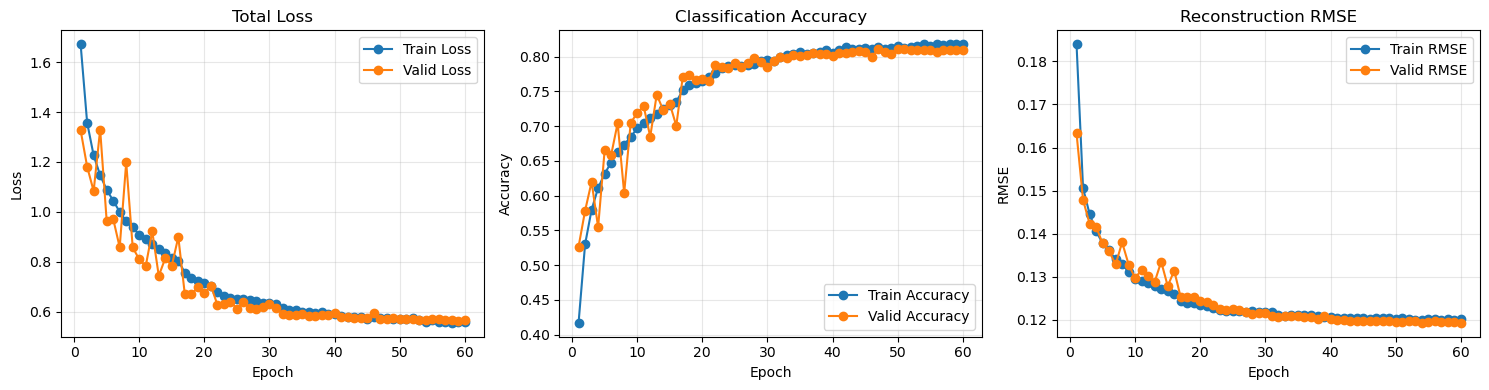

In [16]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training vs validation curves for loss, accuracy, and RMSE.
    Expects a `history` dict from the `train()` function.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(15, 4))

    # ---- 1. Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Valid Loss", marker="o")
    plt.title("Total Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- 2. Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, history["train_acc"], label="Train Accuracy", marker="o")
    plt.plot(epochs, history["val_acc"], label="Valid Accuracy", marker="o")
    plt.title("Classification Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # ---- 3. RMSE
    plt.subplot(1, 3, 3)
    plt.plot(epochs, history["train_rmse"], label="Train RMSE", marker="o")
    plt.plot(epochs, history["val_rmse"], label="Valid RMSE", marker="o")
    plt.title("Reconstruction RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Evaluation & Visual Checks
- [ ] Test accuracy (top-1, optionally top-5)
- [ ] Reconstruction quality (grid of originals vs reconstructions)
- [ ] Extract latents `z` and visualize (PCA/UMAP/t-SNE)

**Verify:** supervised AE should show more separated clusters than AE-only.

In [17]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

# ----------------------------
# 1) Top-1 accuracy on a loader
# ----------------------------
@torch.no_grad()
def test_accuracy(model, loader, device=None):
    """
    Compute top-1 accuracy over a dataloader.
    """
    device = device or next(model.parameters()).device
    model.eval()
    correct, total = 0, 0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        _, _, logits = model(X)
        preds = logits.argmax(dim=1)
        correct += (preds == y).sum().item()
        total   += y.numel()
    return correct / max(1, total)


# ------------------------------------
# 2) Show (and optionally save) recons
# ------------------------------------
@torch.no_grad()
def show_reconstructions(model, loader, n=8, device=None, save_path=None, title="Reconstructions"):
    """
    Display originals (top) and reconstructions (bottom) for n samples from the first batch.
    """
    device = device or next(model.parameters()).device
    model.eval()

    X, _ = next(iter(loader))
    X = X.to(device)[:n]
    _, X_hat, _ = model(X)

    # make a 2-row grid: originals on top, reconstructions below
    both = torch.cat([X, X_hat.clamp(0, 1)], dim=0)
    grid = make_grid(both, nrow=n, padding=2)

    plt.figure(figsize=(1.8*n, 3.6))
    plt.imshow(grid.permute(1, 2, 0).detach().cpu())
    plt.axis("off")
    plt.title(title)
    if save_path is not None:
        plt.savefig(save_path, bbox_inches="tight")
    plt.show()


# --------------------------------
# 3) Extract latents (z) + labels
# --------------------------------
@torch.no_grad()
def extract_latents(model, loader, device=None):
    """
    Returns:
        Z: (N, latent_dim) tensor on CPU
        y: (N,) tensor of labels on CPU
    """
    device = device or next(model.parameters()).device
    model.eval()
    Z_list, y_list = [], []
    for X, y in loader:
        X = X.to(device)
        z, _, _ = model(X)
        Z_list.append(z.detach().cpu())
        y_list.append(y.detach().cpu())
    Z = torch.cat(Z_list, dim=0)
    y = torch.cat(y_list, dim=0)
    return Z, y


# --------------------------------------------
# 4) Reduce to 2D (PCA/TSNE) and scatter-plot
# --------------------------------------------
def plot_latent_2d(Z, y, method='pca', title=None, max_points=None, class_names=None):
    """
    Z: (N, D) tensor or numpy
    y: (N,) tensor or numpy (class ids)
    method: 'pca' or 'tsne'
    class_names: list of class names (len = num_classes)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    Z = Z.detach().cpu().numpy() if hasattr(Z, "detach") else np.asarray(Z)
    y = y.detach().cpu().numpy() if hasattr(y, "detach") else np.asarray(y)

    if max_points is not None and Z.shape[0] > max_points:
        idx = np.random.choice(Z.shape[0], max_points, replace=False)
        Z, y = Z[idx], y[idx]

    # --- Embedding step ---
    if method.lower() == 'pca':
        from sklearn.decomposition import PCA
        emb = PCA(n_components=2).fit_transform(Z)
    elif method.lower() == 'tsne':
        from sklearn.manifold import TSNE
        emb = TSNE(n_components=2, init='pca', learning_rate='auto').fit_transform(Z)
    else:
        raise ValueError("method must be 'pca' or 'tsne'")

    # --- Plotting ---
    plt.figure(figsize=(7, 6))
    unique_classes = np.unique(y)
    for cls in unique_classes:
        mask = (y == cls)
        label = class_names[cls] if class_names is not None and cls < len(class_names) else str(cls)
        plt.scatter(emb[mask, 0], emb[mask, 1], s=12, alpha=0.8, label=label)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.title(title or f"Latent 2D ({method.upper()})")
    plt.legend(markerscale=1.5, fontsize=8, loc='best', frameon=False)
    plt.tight_layout()
    plt.show()


Test accuracy: 0.803


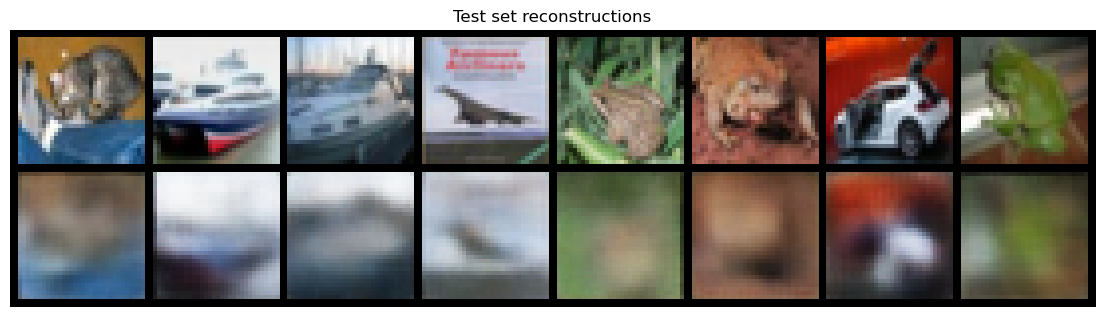

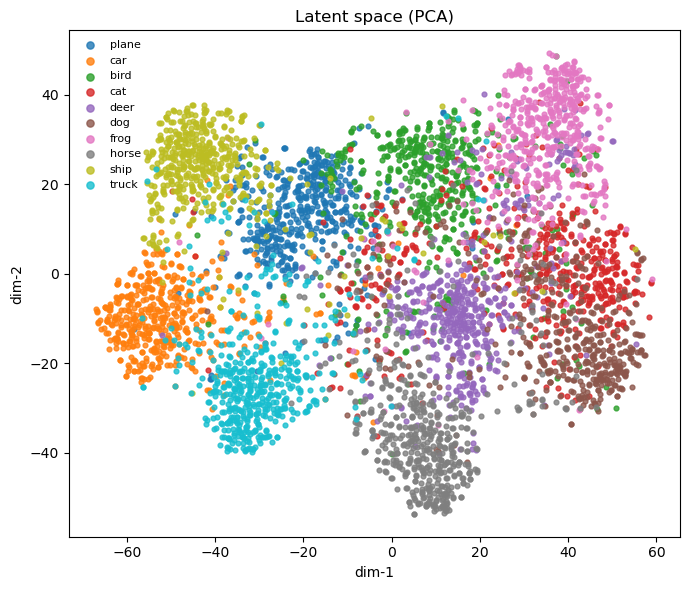

In [18]:
# Accuracy
acc = test_accuracy(ae_model, test_loader)
print(f"Test accuracy: {acc:.3f}")

# Recon grid
show_reconstructions(ae_model, test_loader, n=8, title="Test set reconstructions")

# Latents + 2D visualization
Z, y = extract_latents(ae_model, test_loader)
plot_latent_2d(Z, y, method='tsne', title="Latent space (PCA)", max_points=5000, class_names=cifar10_classes)



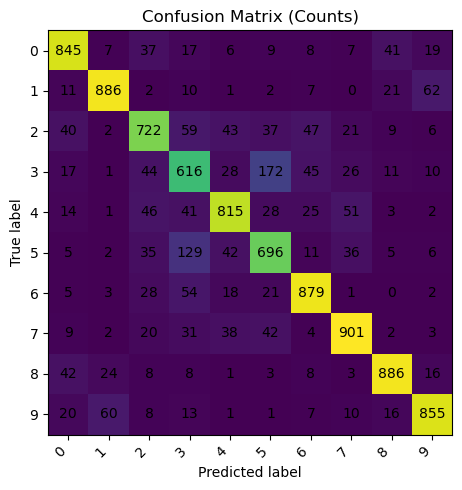

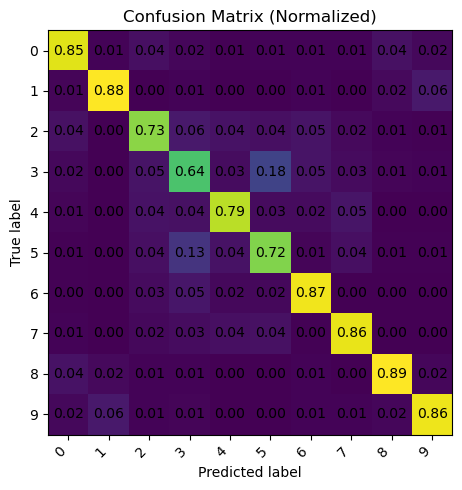

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

@torch.no_grad()
def confusion_matrix_eval(model, loader, device=None, normalize=None, class_names=None, title="Confusion Matrix"):
    """
    Compute and plot a confusion matrix.

    Args:
        model: your SupervisedAE (or any model returning logits)
        loader: dataloader with (X, y)
        device: torch device (inferred if None)
        normalize: None, 'true', 'pred', or 'all' (sklearn semantics)
        class_names: optional list of class names (len == num_classes)
        title: plot title

    Returns:
        cm: numpy array of shape (num_classes, num_classes)
    """
    device = device or next(model.parameters()).device
    model.eval()
    y_true, y_pred = [], []

    for X, y in loader:
        X = X.to(device)
        y_true.append(y.numpy())

        # Forward
        _, _, logits = model(X)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.append(preds)

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, normalize=normalize)

    # Plot (matplotlib only; no seaborn, no custom colors)
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm)  # default colormap

    ax.set_title(title)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    num_classes = cm.shape[0]
    if class_names is None:
        # Try to grab from dataset if available
        try:
            class_names = loader.dataset.classes
            if len(class_names) != num_classes:
                class_names = list(map(str, range(num_classes)))
        except Exception:
            class_names = list(map(str, range(num_classes)))

    ax.set_xticks(range(num_classes))
    ax.set_yticks(range(num_classes))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    # Overlay values
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0 if cm.size else 0.0
    for i in range(num_classes):
        for j in range(num_classes):
            val = cm[i, j]
            ax.text(j, i, format(val, fmt),
                    ha="center", va="center")

    fig.tight_layout()
    plt.show()
    return cm

# No normalization (counts)
cm = confusion_matrix_eval(ae_model, valid_loader, normalize=None, title="Confusion Matrix (Counts)")

# Row-normalized (per true class recall)
cm_norm = confusion_matrix_eval(ae_model, valid_loader, normalize='true', title="Confusion Matrix (Normalized)")


In [20]:
import torch
import numpy as np
from sklearn.metrics import classification_report

@torch.no_grad()
def classification_report_eval(model, loader, device=None, target_names=None,
                               digits=3, output_dict=False, print_report=True):
    """
    Compute a sklearn-style classification report.

    Args:
        model: your model returning (z, x_hat, logits)
        loader: DataLoader of (X, y)
        device: torch device (auto if None)
        target_names: list of class names (len == num_classes) or None to infer from dataset
        digits: number formatting for the report
        output_dict: if True, returns the sklearn dict; else returns the string
        print_report: if True, prints the report

    Returns:
        report (str or dict), y_true (np.ndarray), y_pred (np.ndarray)
    """
    device = device or next(model.parameters()).device
    model.eval()
    y_true, y_pred = [], []

    for X, y in loader:
        X = X.to(device)
        _, _, logits = model(X)
        preds = logits.argmax(dim=1).cpu().numpy()
        y_pred.append(preds)
        y_true.append(y.numpy())

    y_true = np.concatenate(y_true)
    y_pred = np.concatenate(y_pred)

    # class names
    if target_names is None:
        try:
            target_names = loader.dataset.classes
            if len(target_names) != model.num_classes:
                target_names = [str(i) for i in range(model.num_classes)]
        except Exception:
            target_names = [str(i) for i in range(model.num_classes)]

    rep = classification_report(
        y_true, y_pred, target_names=target_names,
        digits=digits, output_dict=output_dict, zero_division=0
    )

    if print_report and not output_dict:
        print(rep)
    elif print_report and output_dict:
        # pretty print a compact table from the dict
        import pandas as pd
        df = pd.DataFrame(rep).transpose()
        print(df.round(digits).to_string())

    return rep, y_true, y_pred

# simple printout
_ = classification_report_eval(ae_model, test_loader, print_report=True)

# # get a dict you can log/save
# rep_dict, y_true, y_pred = classification_report_eval(
#     model, test_loader, output_dict=True, print_report=True
# )

# optional: save to CSV
# import pandas as pd
# pd.DataFrame(rep_dict).transpose().to_csv("classification_report.csv")


              precision    recall  f1-score   support

    airplane      0.805     0.836     0.820      1000
  automobile      0.903     0.879     0.891      1000
        bird      0.749     0.726     0.737      1000
         cat      0.646     0.617     0.631      1000
        deer      0.786     0.781     0.783      1000
         dog      0.701     0.733     0.717      1000
        frog      0.841     0.873     0.857      1000
       horse      0.849     0.828     0.838      1000
        ship      0.883     0.898     0.890      1000
       truck      0.863     0.860     0.862      1000

    accuracy                          0.803     10000
   macro avg      0.803     0.803     0.803     10000
weighted avg      0.803     0.803     0.803     10000



In [21]:
import torch
import numpy as np
from sklearn.metrics import pairwise_distances

def latent_cluster_metrics(Z, y):
    """
    Compute intra/inter class distances and separation ratio.
    Z: (N, D) latent tensor or numpy array
    y: (N,) labels
    """
    if hasattr(Z, "detach"):
        Z = Z.detach().cpu().numpy()
    if hasattr(y, "detach"):
        y = y.detach().cpu().numpy()

    classes = np.unique(y)
    centroids = []
    intra_dists = []

    for c in classes:
        z_c = Z[y == c]
        centroid = z_c.mean(axis=0, keepdims=True)
        centroids.append(centroid)
        # mean pairwise distance within class
        intra = pairwise_distances(z_c, centroid).mean()
        intra_dists.append(intra)

    centroids = np.concatenate(centroids, axis=0)
    # mean pairwise distance between class centroids
    inter = pairwise_distances(centroids).mean()
    intra = np.mean(intra_dists)

    return {"intra": intra, "inter": inter, "ratio": inter / intra}

Z, y = extract_latents(ae_model, test_loader)
metrics = latent_cluster_metrics(Z, y)
print(f"Intra-class dist: {metrics['intra']:.4f}")
print(f"Inter-class dist: {metrics['inter']:.4f}")
print(f"Separation ratio: {metrics['ratio']:.3f}")


Intra-class dist: 5.8505
Inter-class dist: 6.3275
Separation ratio: 1.082


## Ablations & Baselines
- [ ] Classifier-only baseline (λ=0; no decoder)
- [ ] AE-only baseline (train AE, then MLP on frozen z)
- [ ] Supervised AE (main), sweep λ ∈ {0.1, 0.25, 0.5, 1.0}, latent_dim ∈ {32,64,128}

**Record:** accuracy, recon MSE, and latent plots per setting.

## Logging & Checkpoints
- [ ] Save per-epoch metrics (CSV/JSON)
- [ ] Save best model by val accuracy
- [ ] (Optional) TensorBoard

**Verify:** resume training from checkpoint works.

## Notes & Next Steps
- Try label smoothing, dropout, or weight decay tweaks
- Try different reconstruction loss (BCE vs MSE)
- Try data augmentation on/off
- Try OOD score via distance to class centroids in latent space
- Consider VAE version (KL term) once supervised AE is stable